# _kNN_: _k_-Vecinos Cercanos

Es un algoritmo de aprendizaje supervisado en el que se asigna a un punto de prueba, la clase mayoritaria entre los _k_ vecinos más próximos, utilizando una métrica de distancia. En la siguiente figura se puede ver un ejemplo para _k_ = 5

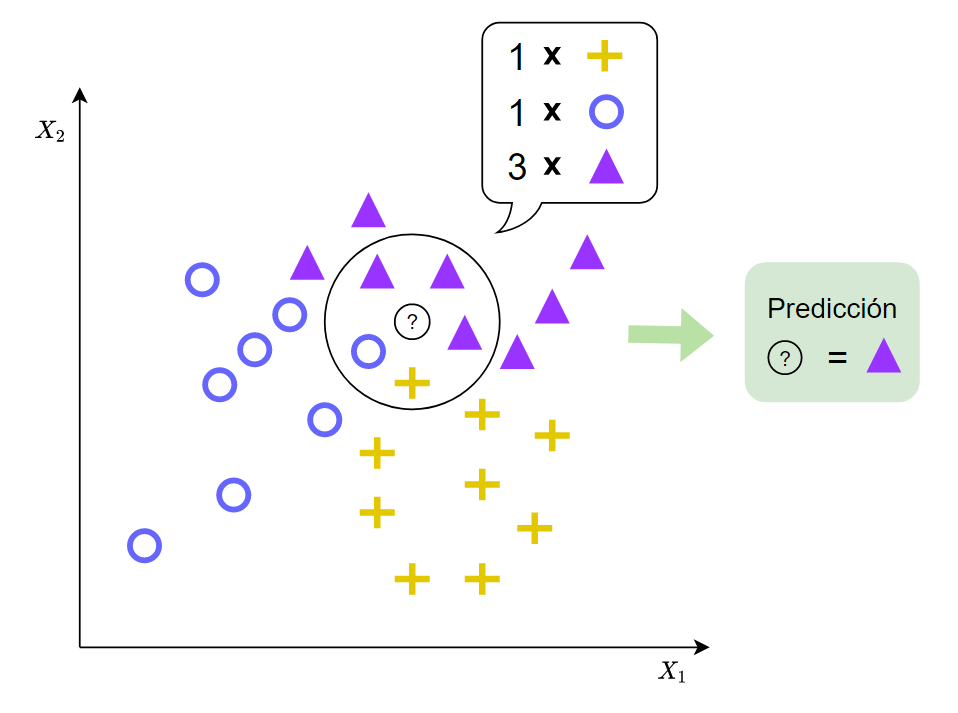

In [1]:
import sys
from IPython.display import Image, display
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Inteligencia Artificial/IA - Clases de Práctica/ContenidosPorTemas'

display(Image(filename='./2_imagenes/knn.png', width=700))

## Métricas de distancia

### Minkowski:$\qquad d(\textbf{x}^{[a]}, \textbf{x}^{[b]}) = [ \sum\limits_{j=1}^{m}{(|x_j^{[a]}-x_j^{[b]}|)^p} ]^{\frac{1}{p}}$

### Manhattan: $\quad p=1 \quad d(\textbf{x}^{[a]}, \textbf{x}^{[b]}) =  \sum\limits_{j=1}^{m}{|x_j^{[a]}-x_j^{[b]}|}$

### Euclídea: $\quad p=2 \quad d(\textbf{x}^{[a]}, \textbf{x}^{[b]}) = \sqrt{ \sum\limits_{j=1}^{m}{(x_j^{[a]}-x_j^{[b]})^2}}$

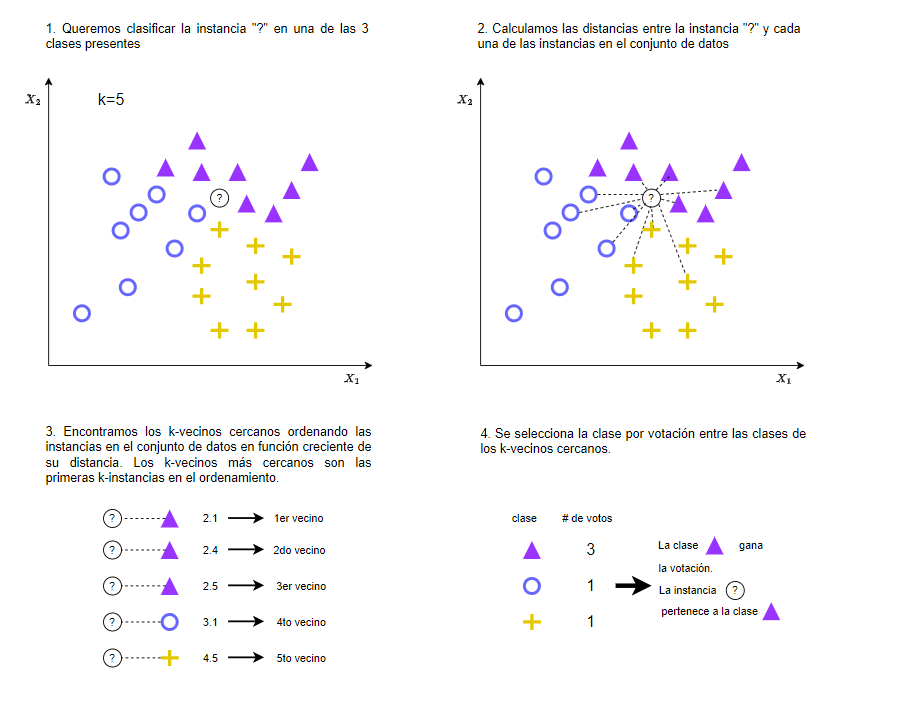

In [2]:
display(Image(filename='./2_imagenes/knn_algo.png', width=900))

## Clase KNN

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [4]:
df_iris = load_iris(as_frame=True).frame
X = df_iris[ ['petal length (cm)', 'petal width (cm)'] ]
y = df_iris.target

In [5]:
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1,  stratify = y)

In [22]:
# Normalización de los datos
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [58]:
class KNN:
    """Clasificador KNN.

    Parámetros
    ------------
    k : int
        número de vecinos cercanos
    p : int
        valor para selección de métrica (1: Manhattan, 2: Euclídea)
    """

    def __init__(self, k=5, p=2):
        self.k = k
        self.p = p

    def distancia(self, vec_1, vec_2, p=2):
        dim = len(vec_1)
        distance=0

        for d in range(dim):
            distance += (abs(vec_1[d]-vec_2[d]))**p

        distance = (distance)**(1/p)
        return distance

    def fit(self, X, y):
        """Entrenamiento del clasificador kNN, es un algoritmo 'perezoso'
        sólo almacena los datos y sus etiquetas
        Parameters
        ----------
        X : array
            vector de características.
        y : array
            clases asociadas a los datos.
        """
        self.X = X
        self.y = y
        self.n_datos = X.shape[0]

    def predict(self, x):
        """Función que realiza la predicción.
        Parameters
        ----------
        x : array
            vector de patrones de entrada.

        Returns
        -------
        vector de predicciones.
        """
        y_pred = []

        for punto_prueba in x:
            #----------------------------------
            distances = [self.distancia(punto_prueba, self.X[i], self.p) for i in range(self.n_datos)]
            sorted_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y[sorted_indices]
            label_counts = np.bincount(k_nearest_labels)
            predicted_label = np.argmax(label_counts)
            y_pred.append(predicted_label)
            #----------------------------------

        return np.asarray(y_pred) #predicciones

## Usamos el clasificador

In [59]:
# reseteo los índices de los datos de entrenamiento
X_train_std = pd.DataFrame(X_train_std).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
# Creamos un objeto knn usando la clase implementada
knn = KNN(k=10)
# llamamos al método de entrenamiento ---> Datos de entrenamiento
knn.fit(X_train_std.to_numpy(), y_train.to_numpy())

In [60]:
# reseteo los índices de los datos de prueba
X_test_std = pd.DataFrame(X_test_std).reset_index(drop=True)
# Evaluamos el clasificador con los datos de prueba
y_pred = knn.predict(X_test_std.to_numpy())
# Comparamos nuestra predicción con los targets
(y_pred==y_test).sum()

44

A continuación vamos a utilizar una función `plot_decision_regions` implementada en el archivo `graficacion.py` de la carpeta `modulos` para graficar las regiones de clasificación.
Se va a crear un mapa de colores en función del resultado de la predicción de nuestro clasificador.
Utilizaremos la misma función con otros clasificadores. Notar que se pasa un clasificador como parámetro y que en su interior se hace una llamada al método `predict()` del clasificador.

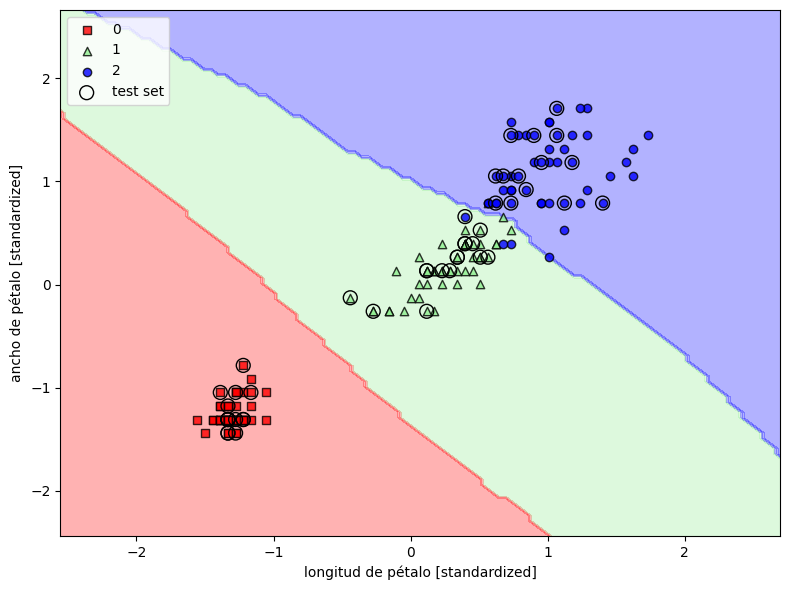

In [61]:
import matplotlib.pyplot as plt
from modulos.graficacion import plot_decision_regions

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plt.figure(figsize=(8,6))
plot_decision_regions( X=X_combined_std, y=y_combined, clasificador=knn, test_idx=range(105, 150), resolution=0.05)
plt.xlabel('longitud de pétalo [standardized]')
plt.ylabel('ancho de pétalo [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [63]:
y_pred = knn.predict(X_test_std.to_numpy())  # predicción de los datos de prueba escalados

In [64]:
def accuracy(y_pred, y_test):
    return np.sum( np.equal(y_pred, y_test) ) / len(y_test)

print(accuracy(y_pred, y_test))


0.9777777777777777


# KNN usando _scikit-Learn_

### Cargamos los datos

El conjunto de datos en el archivo `prestamos.csv` muestra algunos registros de préstamos personales de LendingClub. LendingClub es líder en préstamos entre pares en el que grupos de inversionistas otorgan préstamos personales a individuos. El objetivo del análisis de este conjunto de datos es predecir el resultado de un nuevo préstamo potencial. Las opciones del resultado son: _pagado_ o _incumplido_.

In [9]:
df_prestamos = pd.read_csv("./1_datos/prestamos.csv", index_col=False)
df_prestamos.head()

FileNotFoundError: [Errno 2] No such file or directory: './1_datos/prestamos.csv'

In [ ]:
df_prestamos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tasa de interes       134531 non-null  float64
 1   plazo prestamo        134531 non-null  int64  
 2   fico limite inferior  134531 non-null  float64
 3   fico limite superior  134531 non-null  float64
 4   deudas_ingresos       134503 non-null  float64
 5   estado                134531 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 6.2+ MB


### Visualización de los datos

Utilice la función [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) de seaborn para hacer los gráficos de dispersión de las carcaterísticas de a pares.

In [ ]:
import seaborn as sns

sns.pairplot(df_prestamos, hue="estado")

### Separamos predictores de las etiquetas

In [ ]:
# separar x, y del dataframing

### Dividimos los datos en entrenamiento y prueba

20% datos de prueba, utilice `random_state=42`, estratificar en función de la clase.


**Hay datos faltantes?**


**Es necesario escalar los datos?**

In [ ]:
# es importante para llevar todas las distancias a un mismo rango

### Entrenamiento del clasificador [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Antes de entrenar nuestro clasificador, vamos a dividir los datos de entrenamiento en un conjunto de validación `X_valid` y uno de entrenamiento nuevo. Para esto, tomemos las primeras 20000 muestras como conjunto de validación. No olvidar dividir también las etiquetas.

calcule la tasa de aciertos de las predicciones del clasificador (aciertos/total de etiquetas)

Utilice los datos de validación para estimar un valor adecuado de K. Para esto, grafique la tasa de aciertos (accuray) en función de valores crecientes de K. Utilice la función [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Seleccione el valor de K a partir del cual el clasificdor presenta un desempeño adecuado con los datos de validación. Entrene un nuevo clasificador con este valor de K y evalúe el resultado con los datos de prueba.